# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл
Импортируем все нужные для дальнейшего анализа библиотеки и посмотрим первичную информацию по датасету

In [32]:
# импортируем нужные библиотеки и структуры данных
import pandas as pd
import warnings
from IPython.display import display
from sklearn.model_selection import train_test_split #разделение на выборки
from sklearn.tree import DecisionTreeClassifier #дерево решений
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.linear_model import LogisticRegression #логистическая регрессия
import matplotlib.pyplot as plt

#пандас слишком ругается на мои методы
warnings.filterwarnings("ignore")

df = pd.read_csv('datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Как упоминалось в описании, в данном датасете содержатся данные о клиентах "Мегалайн", которые уже перешли на какой-то из тарифов:
1. Количество звонков за месяц
2. Количество минут за месяц
3. Количество сообщений за месяц
4. Количество потраченных мегабайт за месяц
5. Факт подключения тарифа ultra (1 - подключён ultra, 0 - smart)

Датасет был предоставлен уже предобработанным, поэтому можно приступать к разбиению данных на выборки и работой с моделями.

## Разбейте данные на выборки
Перед созданием и работой с моделями, разобьём имеющиеся данные на три выборки: обучающую, валидационную и тестовую. Выбираться они будут в соотношении 60:20:20, это наиболее применяемое в машинном обучении соотношение.

### Выделение обычных и целевых признаков
Для начала выделим в датасете признаки и целевой признак, которые будут записаны в переменных features и target соответственно. 

In [33]:
#выделим обычные признаки и целевые
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

display('Признаки\n', features)
display('Целевой признак\n', target)

'Признаки\n'

,calls,minutes,messages,mb_used
0,40.0,311.90,83.0,19915.42
1,85.0,516.75,56.0,22696.96
2,77.0,467.66,86.0,21060.45
3,106.0,745.53,81.0,8437.39
4,66.0,418.74,1.0,14502.75
...,...,...,...,...
3209,122.0,910.98,20.0,35124.90
3210,25.0,190.36,0.0,3275.61
3211,97.0,634.44,70.0,13974.06
3212,64.0,462.32,90.0,31239.78


'Целевой признак\n'

0       0
1       0
2       0
3       1
4       0
       ..
3209    1
3210    0
3211    0
3212    0
3213    1
Name: is_ultra, Length: 3214, dtype: int64

### Разбиение на выборки
После дважды применим функцию train_test_split библиотеки sklearn. В первый раз в соотношении 80 на 20, где 80 процентов занимают обучающая и валидационная выборки и 20 - тестовая. Во второй раз в соотношении 75 к 25, где 75 процентов придётся на обучающую выборку и 25 на валидационную. 

In [34]:
# делим выборки на обучающую+валидационную и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.2, 
                                                                            random_state=12189)

# обучаюшую+валидационную делим между собой
features_train, features_valid, target_train, target_valid = train_test_split(features_train, 
                                                                              target_train, 
                                                                              test_size=0.25, 
                                                                              random_state=12189)

# проверяем размеры выборок
print('Размер обучающей выборки:', len(target_train))
print('Размер валидационной выборки:', len(target_valid))
print('Размер тестовой выборки:', len(target_test))

Размер обучающей выборки: 1928
Размер валидационной выборки: 643
Размер тестовой выборки: 643


Обучающая, валидационная и тестовая выборки готовы. Теперь можно приступить к созданию и обучению моделей.

## Исследуйте модели
Принадлежность к тарифу 'ultra' - это категориальная переменная, следовательно перед нами стоит задача классификации (это уже известно из описания проекта, но стоит повторить). Нашей целью является создание модели, которая наиболее точно классифицирует пользователей в тестовой выборке. 

В данном проекте будет рассмотрено только три модели классификации: дерево решений, случайный лес и логистическая регрессия. Каждая из них будет по очереди проверена на долю правильных ответов и среди всех мы выберем самую точную.

### Дерево решений
Самая простая модель - это дерево решений. Она обучается быстрее всех вышеперечисленных, но имеет наименьшую точность.

Для того, чтобы создать данную модель, импортируем структуру данных 'DecisionTreeClassifier' из библиотеки sklearn и создадим объект этой структуры.

Точность модели будет проверена при различных значениях (от 1 до 10). Среди результатов будет выбрана наибольшая.

In [35]:
# задаём переменные для определения лучшей модели и лучшего результата точности на валидационной выборке
best_model_tree = None #лучшая модель
best_result_tree = 0 #лучшая точность

# обучаем модель на обучающей выборке и выбираем оптимальную глубину (при которой будет наибольшая точность)
for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=12189, max_depth=depth) # создаём объект структуры дерева решений
    model_tree.fit(features_train, target_train)
    result = model_tree.score(features_valid, target_valid)
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        
print('Наибольшая точность модели дерева решений на валидационной выборке:', best_result_tree)

Наибольшая точность модели дерева решений на валидационной выборке: 0.8087091757387247


80 процентов на валидационной выборке. Достаточно неплохо, но тестовой явно будут различия, причём в худшую сторону. Проверим другие модели.

### Случайный лес 
Случайный лес по своей сути является объединением нескольких деревьев решений. Обучается намного дольше, потому что работа идёт с несколькими деревьями, но точность будет выше, чем у просто дерева.

Для того, чтобы создать модель случайного леса, импортируем структуру 'RandomForestClassifier' из библиотеки sklearn и создадим объект этой структуры.

Точность модели будет проверена при разном количестве деревьев (10, 20, 30, 40 и 50) с разной глубиной (от 1 до 10). Среди них будет выбрана модель с наибольшим результатом правильных предсказаний на валидационной выборке.

In [36]:
# задаём переменные для определения лучшей модели и лучшего результата точности на валидационной выборке
best_model_forest = None
best_result_forest = 0

# обучаем модель на обучающей выборке и выбираем опттимальную глубину и количество деревьев, которые покажут лучший результат
for est in range(10, 51, 10):
    for depth in range(1, 11):
        model_forest = RandomForestClassifier(random_state=12189, max_depth=depth, n_estimators=est)
        model_forest.fit(features_train, target_train)
        result = model_forest.score(features_valid, target_valid)
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result
            
print('Наибольшая точность модели случайного леса на валидационной выборке:', best_result_forest)

Наибольшая точность модели случайного леса на валидационной выборке: 0.8211508553654744


82 процента на валидационной выборке. Уже лучше дерева решений, но стоит посмотреть результаты у логистической регрессии, вдруг они будут лучше.

### Логистическая регрессия
Логистическая регрессия по своей скорости обучения и точности будет чем-то средним между деревом решений и случайным лесом. 

Для того, чтобы создать модель логистической регрессии, импортируем структуру 'LogisticRegression' из библиотеки sklearn и создадим обхект этой структуры.

У данной модели мало параметров, которые можно менять, поэтому мы проверим её точность только при параметрах по умолчанию.

In [37]:
# обучаем модель на обучающей выборке
best_model_logistic = LogisticRegression(random_state=12189)
best_model_logistic.fit(features_train, target_train)
result = best_model_logistic.score(features_valid, target_valid)

# для удобства сохраняем результаты в других переменных
best_result_logistic = result

print('Точность модели логистической регресси на валидационной выборке:', best_result_logistic)

Точность модели логистической регресси на валидационной выборке: 0.7744945567651633


Точность модели логистической регресии, как и предполагалось, выше точности дерева, но меньше точности случайного леса.

Мы рассмотрели три модели и пришли к выводу, что самой точной для данной задачи будет модель случайного леса. 

## Проверьте модель на тестовой выборке
На валидационной выборке лучшую точность показала модель случайного леса. Поэтому проверим её на тестовой выборке.

In [38]:
# смотрим точность выбранной модели на тестовой выборки
best_model_forest.score(features_test, target_test)

0.7916018662519441

Точность предсказаний немного упала, но всё равно держится на достаточно высоком уровне.

Проверив работу модели на тестовой выборке, приходим к тому, что лучше всего себя в данной задаче показывает модель случайного леса. Её точность превысила 0.75, задание выполнено.

## (бонус) Проверьте модели на адекватность
Теперь проверим самую точную модель на адекватность. Адекватность модели определяется пригодностью для решения поставленной задачи.

Для того, чтобы это сделать, построим гистограму верного результата, а также предсказаний на модели случайного леса.

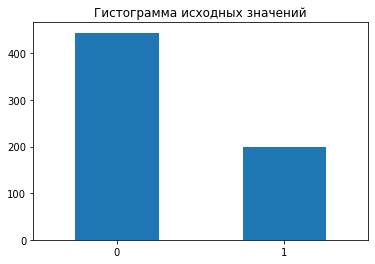

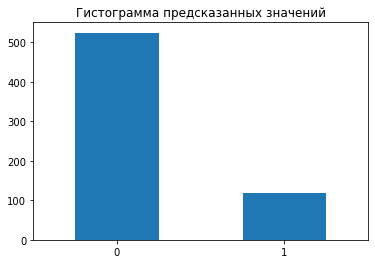

In [39]:
# гистограмма целевого признака у тестовой выборки
target_test.value_counts().plot(kind='bar', rot=0) #строим гистограмму
plt.title('Гистограмма исходных значений')
plt.show()

# гистограмма целевого признака предсказаний по предсказаниям модели
predict_forest = pd.Series(best_model_forest.predict(features_test)) # получаем массив предсказаний лучшей моделью
predict_forest.value_counts().plot(kind='bar', rot=0) #строим гистограмму
plt.title('Гистограмма предсказанных значений')
plt.show()

По гистограммам видим, что значения сильно отличаются: '1' почти на сотню меньше в Series предсказанных значений. Но это и не удивительно, точность модели на тестовой выборке равна 79%. По сути каждое пятое предсказание неверно. Если смотреть в общем, то гистограммы всё равно похожи и уже из них можно сделать вывод об адекватности модели.

Для того, чтобы точно удостовериться в этом, сравним статистические метрики: среднее и дисперсию.

In [40]:
# находим дисперсию и среднее исходных значений
start_var = target_test.var()
start_mean = target_test.mean()

# находим дисперсию и среднее предсказанных значений
predict_var = predict_forest.var()
predict_mean = predict_forest.mean()

print('Дисперсия исходных значений:', round(start_var, 2))
print('Дисперсия предсказанных моделью значений:', round(predict_var, 2), '\n')

print('Среднее исходных значений:', round(start_mean, 2))
print('Среднее предсказанных моделью значений', round(predict_mean, 2))

Дисперсия исходных значений: 0.21
Дисперсия предсказанных моделью значений: 0.15 

Среднее исходных значений: 0.31
Среднее предсказанных моделью значений 0.19


Дисперсия у обоих Series отличается очень слабо. Среднее у них разнится больше, но это связано тем, что у результатов модели на целую сотню больше нулей и соответственно меньше единиц.

Самым точной проверкой на адекватность будет проверка сравнение с модель DummyClassifier - фиктивным классификатором, который зачастую даёт случайные ответы.

In [41]:
from sklearn.dummy import DummyClassifier #импортируем фиктивный классификатор

dummy_model = DummyClassifier(strategy="most_frequent") #создаём объект структуры данныъ DummyClassifier
dummy_model.fit(features_train, target_train) #обучаем модель на обучающей выборке
dummy_model.score(features_test, target_test) #проверяем точность модели

0.6905132192846034

Как мы помним, точность случайного леса на тестовых данных равнялась 79%, что на 10% больше результата фиктивной модели.

Из всех вышепроведённых проверок можем сделать вывод, что модель прошла проверку на адекватность.

## Общий вывод

В данном проекте мы получили датасет с данными клиентов, перешедших на один из тарифов 'Мегалайна', разделили его на три выборки: обучающую, валидационную и тестовую.

После этого мы обучили три вида моделей на обучающей выборке: дерево решений, случайный лес и логистическую регрессию. Далее мы выбрали ту, что показала наилучший результат на валидационной выборке. Ей оказалась модель случайного леса, она показала точность 79 процентов на тестовой выборке.

В качестве дополнительного исследования мы провели проверку на адекватность на лучшей модели, её пригодность для выполнения данной задачи, и пришли к выводу, что она её прошла.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
